# Objective
Create a model using advanced techniques for a case study of a prediction model that can be used to evaluate loan repayment behaviour of currently excluded customers of formal financial services
https://www.kaggle.com/c/home-credit-default-risk

# Potentential improvements

- Use unbalanced dataset vs artificially balanced
- Use a different method of feature selection (*e.g. correlation, Recursive feature selection*) 
- Include more or different algorithms
- Include more parameters as part of the Hyper Parameter Tuning process

# Preparation

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn import preprocessing
from sklearn import metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.utils import resample
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from scipy.stats import randint
import os
import errno

In [2]:
%load_ext pycodestyle_magic
%flake8_on
%matplotlib inline

### Create folder structure

In [3]:
os.chdir('..')
output_folder = './reports/figures/advanced/'
cleaned_folder = './data/processed/advanced/'
external_data = './data/external/advanced/'

# Import data

In [4]:
x_train = pd.read_csv(cleaned_folder + 'x_train.csv')
x_test = pd.read_csv(cleaned_folder + 'x_test.csv')
y_train = pd.read_csv(cleaned_folder + 'y_train.csv', dtype='int64')
y_test = pd.read_csv(cleaned_folder + 'y_test.csv', dtype='int64')
test_df = pd.read_csv(cleaned_folder + 'test_df.csv')
test_ids_df = pd.read_csv(cleaned_folder + 'test_ids_df.csv')

In [5]:
y_test = y_test['TARGET']
y_train = y_train['TARGET']

# Balance dataset

In [6]:
# Verify that the dataset is balanced
y_train.value_counts(normalize=False)

0    178881
1     15945
Name: TARGET, dtype: int64

**Result**: dataset unbalanced with only 9% customers with payment difficulties, which can be expected.

*While some algorithms can work with unbalanced datasets, we will be balancing the dataset to allow for algorithms that require a balanced sample.*

In [7]:
# Merge outcome variable & features
train_df = pd.concat([x_train, y_train], axis=1)

In [8]:
# Separate dataset based on outcome variable
no_pay_prob = train_df[train_df['TARGET'] == 0]
pay_prob = train_df[train_df['TARGET'] == 1]

In [9]:
# upsample - artificially add customers with payment difficulties
# Reason for upsampling is that our dataset is relatively small
pay_prob2 = resample(pay_prob,
                     replace=True,  # sample with replacement
                     n_samples=len(no_pay_prob),  # dataset to match customers without payment problems
                     random_state=18)

In [10]:
# Count of customers with payment difficulties
pay_prob.shape

(15945, 16)

In [11]:
# New count of customers without payment difficulties
pay_prob2.shape

(178881, 16)

In [12]:
# Combine dataset with added cases
train_df = pd.concat([pay_prob2, no_pay_prob])

In [13]:
# Separate dataset in preparation of modelling
y_train = train_df['TARGET']
x_train = train_df.drop('TARGET', axis=1)

# Feature selection

In [14]:
rf_feature_select = SelectFromModel(RandomForestClassifier(n_estimators=100))
rf_feature_select.fit(x_train, y_train)

rf_sel_feature_count = rf_feature_select.get_support()
rf_selected_features = x_train.loc[:, rf_sel_feature_count].columns.tolist()
print(str(len(rf_selected_features)), 'selected features')

7 selected features


In [15]:
print('Selected features:', rf_selected_features)

Selected features: ['DAYS_ID_PUBLISH_DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED_DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE_DAYS_BIRTH', 'REGION_POPULATION_RELATIVE_DAYS_EMPLOYED', 'REGION_POPULATION_RELATIVE_DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS_DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE_DAYS_LAST_PHONE_CHANGE']


In [16]:
# Select strongest features
x_train = x_train[rf_selected_features]
x_test = x_test[rf_selected_features]
test_df = test_df[rf_selected_features]

# Algorithm selection

In [17]:
classifiers = {'KNN': KNeighborsClassifier(),
               'Random Forest Classifier': RandomForestClassifier(),
               'Decision Tree Classifier': DecisionTreeClassifier(),
               'Logistic Regression': LogisticRegression()}

In [18]:
# Evaluate strongest predicting algorithm in default setting
base_score = 0
model_outcomes = []
for Name, classify in classifiers.items():
    classify.fit(x_train, y_train)
    predicting_y = classify.predict(x_test)
    model_outcomes.append({'Algorithm': str(Name),
                           'f1_score': str(met.f1_score(y_test, predicting_y))})
    if met.f1_score(y_test, predicting_y) > base_score:
        # prediction = classify.predict(test_df)
        base_score = met.f1_score(y_test, predicting_y)

    else:
        continue

8:28: E126 continuation line over-indented for hanging indent


Best performing algorithms according to the F1 score

In [19]:
model_scores = pd.DataFrame(model_outcomes, columns=['Algorithm', 'f1_score'])
model_scores.sort_values(by=['f1_score'], ascending=False)

,Algorithm,f1_score
3,Logistic Regression,0.17910090388490932
0,KNN,0.13748982203094104
2,Decision Tree Classifier,0.09185619955979459
1,Random Forest Classifier,0.006394217403391716


Best algorithms according to model evaluation:
<ol>
<li> GaussianNB </li>
<li> BernoulliNB </li>
<li> Linear Discriminant Analyis </li>
<li> Logistic regression </li>

# Hyper parameter tuning
Optimise the top performing algorithm parameters to create the best possible prediction.

In [20]:
classifiers = {'Random_forest': {'model': RandomForestClassifier(),
                                 'params': {'n_estimators': [31, 35, 37]}},
               'Logistic_regression': {'model': LogisticRegression(solver='liblinear', multi_class='auto'),
                                       'params': {'C': [1, 10, 100, 1000],
                                                  'penalty': ['l1', 'l2'], }},
               'KNearestNeighbors': {'model': KNeighborsClassifier(),
                                     'params': {'n_neighbors': [2, 5, 7],
                                                'metric': ['euclidean', 'minkowski']}},
               'DecisionTreeClassifier': {'model': DecisionTreeClassifier(),
                                          'params': {'criterion': ["gini", "entropy"],
                                                     'splitter': ['best', 'random'],
                                                     'max_depth': [3, None],
                                                     'max_features': [1, 5, 9],
                                                     'min_samples_leaf': [1, 5, 9]}}}

In [27]:
# Select classifier algorithms to optimise
scores = []
for model_name, mp in classifiers.items():
    grid = GridSearchCV(mp['model'],
                        mp['params'],
                        cv=10,
                        scoring='f1',
                        return_train_score=False,
                        n_jobs=-1)
    grid.fit(x_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

In [28]:
# Create table with best parameters per algorithm
model_parameters = pd.DataFrame(scores, columns=['model',
                                                 'best_score',
                                                 'best_params'])
model_parameters.sort_values(by=['best_score'], ascending=False)

,model,best_score,best_params
0,Random_forest,0.995212,{'n_estimators': 35}
3,DecisionTreeClassifier,0.959165,"{'criterion': 'gini', 'max_depth': None, 'max_..."
2,KNearestNeighbors,0.957022,"{'metric': 'euclidean', 'n_neighbors': 2}"
1,Logistic_regression,0.598086,"{'C': 10, 'penalty': 'l2'}"


**Result:** models perform slightly better than before parameter optimisation

# Modelling

Use the earlier identified top 3 algorithms with best performing parameters

In [102]:
model1 = RandomForestClassifier(n_estimators=35)
model1.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=35,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [75]:
model2 = DecisionTreeClassifier(criterion='gini',
                                max_depth=None,
                                max_features=1,
                                min_samples_leaf=1,
                                splitter='best')
model2.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [80]:
model3 = KNeighborsClassifier(metric='euclidean',
                              n_neighbors=2)
model3.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [82]:
model4 = LogisticRegression(C=10,
                            penalty='l2')
model4.fit(x_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Model evaluation

In [83]:
# Create predictions from the training data on the test data
y_pred_mod_1 = model1.predict(x_test)
y_pred_mod_2 = model2.predict(x_test)
y_pred_mod_3 = model3.predict(x_test)
y_pred_mod_4 = model4.predict(x_test)

In [84]:
# Evaluate model based on training data
pred_prob_1 = model1.predict_proba(x_test)
pred_prob_2 = model2.predict_proba(x_test)
pred_prob_3 = model3.predict_proba(x_test)
pred_prob_4 = model4.predict_proba(x_test)

In [85]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_1[:, 1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob_2[:, 1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob_3[:, 1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob_4[:, 1], pos_label=1)

In [86]:
# Create benchmark predictions based on random chance for ROC comparison
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [87]:
# Calculate auc scores
auc_score1 = roc_auc_score(y_test, pred_prob_1[:, 1])
auc_score2 = roc_auc_score(y_test, pred_prob_2[:, 1])
auc_score3 = roc_auc_score(y_test, pred_prob_3[:, 1])
auc_score4 = roc_auc_score(y_test, pred_prob_4[:, 1])

print('Model1 AUC:', auc_score1, 'Model2 AUC:', auc_score2, 'Model3 AUC:', auc_score3, 'Model4 AUC:', auc_score4)

Model1 AUC: 0.5674647805745028 Model2 AUC: 0.5115166366397115 Model3 AUC: 0.5113705474703227 Model4 AUC: 0.5895155231447933


In [103]:
# Model names
model_1 = 'Random Forest'
model_2 = 'DecisionTreeClassifier'
model_3 = 'KNeighborsClassifier'
model_4 = 'LogisticRegression'

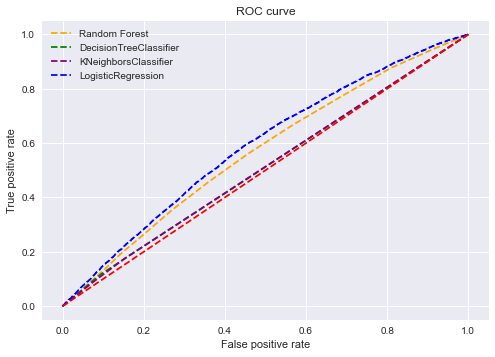

In [112]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', color='orange', label=model_1)
plt.plot(fpr2, tpr2, linestyle='--', color='green', label=model_2)
plt.plot(fpr3, tpr3, linestyle='--', color='purple', label=model_3)
plt.plot(fpr4, tpr4, linestyle='--', color='blue', label=model_4)
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend(loc='best')
plt.savefig(cleaned_folder + 'ROC_graph_advanced', dpi=300)
plt.show()

Based on the above AUC, the Logistic Regression Classifier is the best performing algorithm.

In [89]:
# Create confusion matrix
print("Confusion matrix model 1")
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(y_pred_mod_1, name='Predicted')
pd.crosstab(y_actual, y_predicted)

Confusion matrix model 1


Predicted,0,1
Actual,,
0,76183,348
1,6942,25


In [90]:
print(classification_report(y_predicted, y_actual))

              precision    recall  f1-score   support

           0       1.00      0.92      0.95     83125
           1       0.00      0.07      0.01       373

    accuracy                           0.91     83498
   macro avg       0.50      0.49      0.48     83498
weighted avg       0.99      0.91      0.95     83498



In [91]:
# Create confusion matrix
print("Confusion matrix model 2")
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(y_pred_mod_2, name='Predicted')
pd.crosstab(y_actual, y_predicted)

Confusion matrix model 2


Predicted,0,1
Actual,,
0,69286,7245
1,6147,820


In [92]:
print(classification_report(y_predicted, y_actual))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     75433
           1       0.12      0.10      0.11      8065

    accuracy                           0.84     83498
   macro avg       0.51      0.51      0.51     83498
weighted avg       0.83      0.84      0.83     83498



In [93]:
# Create confusion matrix
print("Confusion matrix model 3")
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(y_pred_mod_3, name='Predicted')
pd.crosstab(y_actual, y_predicted)

Confusion matrix model 3


Predicted,0,1
Actual,,
0,70321,6210
1,6303,664


In [94]:
print(classification_report(y_predicted, y_actual))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     76624
           1       0.10      0.10      0.10      6874

    accuracy                           0.85     83498
   macro avg       0.51      0.51      0.51     83498
weighted avg       0.85      0.85      0.85     83498



In [95]:
# Create confusion matrix
print("Confusion matrix model 4")
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(y_pred_mod_4, name='Predicted')
pd.crosstab(y_actual, y_predicted)

Confusion matrix model 4


Predicted,0,1
Actual,,
0,37869,38662
1,2479,4488


In [96]:
print(classification_report(y_predicted, y_actual))

              precision    recall  f1-score   support

           0       0.49      0.94      0.65     40348
           1       0.64      0.10      0.18     43150

    accuracy                           0.51     83498
   macro avg       0.57      0.52      0.41     83498
weighted avg       0.57      0.51      0.41     83498



# Create final model

In [97]:
# Combine train and test datasets
x_df = pd.concat([x_train, x_test])
y_df = pd.concat([y_train, y_test])

In [108]:
# Apply the best performing model with best parameters to the train and test dataset
model4.fit(x_df, y_df)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Submission

In [109]:
# Create predictions based on generated model
prediction = model4.predict(test_df)

In [110]:
# Generate Submission File
SK_ID_CURR = list(test_ids_df['SK_ID_CURR'])
predicted_test_values = pd.DataFrame({'SK_ID_CURR': SK_ID_CURR, 'TARGET': prediction})
predicted_test_values.to_csv(external_data + 'Submission_file.csv', index=False)

In [111]:
prediction.shape

(43387,)